# Basic API for qttpdesolver package.

For illustration, we consider below the case of SolverFs (a new Finite Sum solver) and 2D stationary diffusion type PDE with scalar coefficient.

### First of all, we have to import  the main classes, functions and constants:

- Pde - is a class that represent equation. It collect benchmarks (prepared model PDEs), coefficients and parameters of calculation. The calculation results are also stored (automatically) in the instance of this class.

- SolverFs - is a class with new Finite Sum solver. It use calculation parameters from the PDE class instance and save calculation results to PDE class instance.

- auto_solve - is a very usefull function that perfom all required steps to solve PDE and prepare results (if it is not used, then special functions construct_solution, construct_derivative, construct_energy and construct_uf have to be called explicitly).

- MODE_NP, MODE_TT, MODE_SP - are the constants that indicate the mode of calculation (numpy or tensor train or scipy sparse respectively). Note: MODE_SP is not available for the SolverFs. 

In [1]:
%matplotlib inline
import numpy as np

from qttpdesolver import Pde, SolverFs, auto_solve, MODE_NP, MODE_TT, MODE_SP

### We'll also import some additional functions (only for test perposes):

(this functions are called from auto_solve function automatically)

In [2]:
from qttpdesolver.solve import construct_solution, construct_derivative, construct_energy, construct_uf

### Now we'll construct a PDE:

(model parameters should be set explicitly)

In [3]:
PDE = Pde()
PDE.txt = 'Simple 2D PDE for test' # It will be used in results representation
PDE.dim = 2                        # Dimension of the spatial variable
PDE.L   = 1.                       # Domain size (this variable is not used in current version: L=1 always)
 
# We set functions for coefficient, rhs and solution of the model PDE (-1.)*div (k grad u) = f
# (all functions should have the same arguments)

def k_func(x, y, w1, w2):
    return 1. + x*y

def f_func(x, y, w1, w2):
    xy = x*y; xy2 = xy*y
    s1 = np.sin(w1*x*x); s2 = np.sin(w2*y)
    c1 = np.cos(w1*x*x); c2 = np.cos(w2*y)
    return (4.*w1*w1*x*x + w2*w2)*(1. +xy2)*s1*s2\
          - 2.*w1*(1. + 2.*xy2)*c1*s2 - 2.*w2*xy*s1*c2

def u_func(x, y, w1, w2):
    return np.sin(w1*x*x)*np.sin(w2*y)

def ux_func(x, y, w1, w2):
    return w1*2.*x*np.cos(w1*x*x)*np.sin(w2*y)

def uy_func(x, y, w1, w2):
    return w2*np.sin(w1*x*x)*np.cos(w2*y)

# And now we set this functions as parameters of PDE class instance
# (txt descriptions will be used for output)

PDE.k_txt = 'k  = 1+x*y^2' 
PDE.k = k_func

PDE.f_txt = 'f  = ... according to exact solution u'
PDE.f = f_func

PDE.u_txt = 'u  = sin(w_1 x^2) sin(w_2 y)'
PDE.u = u_func   # analytical solution

PDE.ux_txt = 'ux = 2 w_1 x cos(w_1 x^2) sin(w_2 y)'
PDE.ux = ux_func # analytical du/dx

PDE.uy_txt = 'uy = w_2 sin(w_1 x^2) cos(w_2 y)'
PDE.uy = uy_func # analytical du/dy

# We have to set also parameters values and text description
PDE.params_txt = 'w1 [=%-8.4f], w2 [=%-8.4f]'
PDE.set_params([np.pi/PDE.L, np.pi/PDE.L * 2])

# This function present current model
PDE.present_model()

PDE:        Simple 2D PDE for test
Parameters: w1 [=3.1416  ], w2 [=6.2832  ]
k  = 1+x*y^2
f  = ... according to exact solution u
u  = sin(w_1 x^2) sin(w_2 y)
ux = 2 w_1 x cos(w_1 x^2) sin(w_2 y)
uy = w_2 sin(w_1 x^2) cos(w_2 y)



### Compact form

The code from the previous cell may be rewritten in a more compact form if we use a model from gallery:

In [4]:
PDE = Pde()
PDE.present_models()
print '-'*50
PDE.set_model('Simple. Analyt 2D diffusion PDE') # number (1) or name of the model may be used
PDE.set_params([np.pi, np.pi*2])                 # default values of parameters can be changed
PDE.present_model()

The following models are available:
# 0. Name: |Simple. Analyt 1D diffusion PDE|
-div(k grad u) = f; x in [0, 1]; u_d = 0. A case of 1d PDE with known exact solution
# 1. Name: |Simple. Analyt 2D diffusion PDE|
-div(k grad u) = f; (x,y) in [0, 1]^2; u_d = 0. Assymetric case with known exact solution
# 2. Name: |Simple. Analyt 3D diffusion PDE|
-div(k grad u) = f; (x,y,z) in [0, 1]^3; u_d = 0. Assymetric case with known exact solution
# 3. Name: |Simple. Msc 1D diffusion PDE|
-div(k^e grad u^e) = f; x in [0, 1]; u_d = 0. A case of 1d multiscale PDE
# 4. Name: |Simple. Msc 2D diffusion PDE|
-div(k^e grad u^e) = f; x in [0, 1]^2; u_d = 0. A case of 2d multiscale PDE
# 5. Name: |Simple. Msc 3D diffusion PDE|
-div(k^e grad u^e) = f; x in [0, 1]^3; u_d = 0. A case of 3d multiscale PDE
# 6. Name: |Simple. 1D diffusion PDE with rhs=1|
-div(k grad u) = f; x in [0, 1]; u_d = 0., f=1
# 7. Name: |Simple. 2D diffusion PDE with rhs=1|
-div(k grad u) = f; (x,y) in [0, 1]^2; u_d = 0., f=1
# 8. Name: |

### Next, we have to set parameters of the calculation:

In [5]:
PDE.set_mode(MODE_TT)            # Calculation mode (NP: numpy, TT:tensor train or SP: scipy sparse)
                                 # (MODE_SP is not available for FS-solver)
PDE.set_solver_txt('fs')         # Name of the solver ('fs' or 'fd')
                                 # (if auto_solve is used then solver will be selected according to this setting)
PDE.set_verb(verb_gen=True,      # If is True then general info will be printed while calculation
             verb_cross=False,   # If is True then cross approximation info will be printed while calculation
             verb_amen=False)    # If is True then AMEn info will be printed while calculation
PDE.set_with_en(True)            # If is True, then energy will be calculated
PDE.set_tau(tau_round=1.E-10,    # Accuracies of calculation (see description in the output below)
            tau_cross=1.E-10,    # (auto selection is used according to simple rules, 
            tau_amens=1.E-6)     # see PDE.set_tau function code for details)
# Settings for (AMEn) solver
# If tau_u_calc_from_algss is True (default), then u_calc will be conscructed with accuracy
# that is equal to real obtained accuracy of AMEn solver,
# if is False, then tau_amens will be used instead.
PDE.set_algss_par(nswp=20, kickrank=4, local_prec='n', local_iters=2,
                  local_restart=20, trunc_norm=1, max_full_size=100,
                  tau_u_calc_from_algss=True)
PDE.present_info() # This function prints current settings

__________________General parameters
Mode             : MODE_TT (tensor train format)
Solver           : fs
Model num        : 1 
Parameters       : w1 [=3.1416  ], w2 [=6.2832  ]
with_en          : True
__________________Verbosity parameters
verb_gen         : True
verb_cross       : False
verb_amen        : False
print_to_std     : True
print_to_file    : False
__________________TT parameters
mgen       (round/cross/amens) : 1.00e-10     / 1.00e-10     / None         
           * Matrices (iD, Q, W,...) construction 
sgen       (round/cross/amens) : 1.00e-10     / None         / None         
           * Matrix A and vector rhs construction 
solve      (round/cross/amens) : 1.00e-06     / None         / 1.00e-06     
           * Solution of the system A w_x = rhs and splitting of block system solution 
u_calc     (round/cross/amens) : 1.00e-06     / None         / None         
           * Rounding of calculated solution 
u_real     (round/cross/amens) : 1.00e-08     / 1.00e-08  

### PDE solution:

In [6]:
# We set value of d. This function also recalculates
# n=2**d (a number of grid nodes along one axis) and h=1/n (grid step).
PDE.update_d(6)

# We remove results of the previous calculations (it's necessary only for the case
# then the same PDE instance is used for several calculations):
PDE.clean()

# We create solver class instance and explicitly call 3 main functions:
PDESolver = SolverFs(PDE)
PDESolver.generate_matrices()
PDESolver.generate_system()
PDESolver.solve() 

# This functions calculate errors, eranks, derivatives, energy and so on:
construct_solution(PDE)
construct_derivative(PDE)
if PDE.with_en:
    construct_energy(PDE)  
    
# This function presents result in a one string mode:
PDE.present_res_1s()

Time of matrices generation: 0.7660  
Time of system generation  : 0.0941  
Time of system solving     : 0.3831  
d=6 |fs-tt|er=6.8e-04 |erdx=4.9e-02 |erdy=3.2e-02 |ere=2.3e-03 |T=1.243  |R=4.5  |It=2 


### Compact form:

The code from the previous cell may be rewritten in a more compact form if we use an auto_solve function:

In [7]:
PDE.update_d(6)
PDE.set_verb(verb_gen=True, verb_cross=False, verb_amen=True) 
PDESolver = auto_solve(PDE, return_solver=True)

Time of matrices generation: 0.7501  
Time of system generation  : 0.1310  
amen_solve: swp=1, max_dx= 9.531E-01, max_res= 9.238E-01, max_rank=12
amen_solve: swp=2, max_dx= 4.975E-07, max_res= 3.386E-07, max_rank=12
Time of system solving     : 0.3540  
Time of additional calcs.  : 0.9350  
d=6 |fs-tt|er=6.8e-04 |erdx=4.9e-02 |erdy=3.2e-02 |ere=2.3e-03 |T=1.235  |R=4.5  |It=2 


### The output in the 1-string mode has the following sense:
- d=6 - is a parameter in formula n=2^d,
- fs-tt - is a name of the used solver and a calculation mode,
- er=6.8e-04 - is the error of solution vs analytical (if it's known),
- erdx=4.9e-02 - is the error of x-derivative vs analytical (if it's known),
- erdy=3.2e-02 - is the error of y-derivative vs analytical (if it's known),
- ere=2.3e-03  - is the error of energy vs analytical (if it's known),
- T=1.196 - is the time of calculation in seconds (an exact numerical values may depend on work station, which is used for computations),
- R=4.6 - is the e-rank of the calculated solution (since random restart in AMEn-solver is used, the rank can vary within a small range),
- It=2 - is a number of AMEn iterations,



### Then we can present the calculation results:

PDE                           : -div(k grad u) = f; (x,y) in [0, 1]^2; u_d = 0. Assymetric case with known exact solution
PDE mode                      : MODE_TT (tensor train format)
Used PDE solver               : fs
PDE dimension                 : 2   
Value of d                    : 6   
Mesh 1D size                  : 64  
Solution erank                : 4.51  
Analit. sol. erank            : 2.82  
Solution error                : 6.77e-04
X-derivative error            : 4.91e-02
Y-derivative error            : 3.23e-02
Energy real                   : 13.1526197470   
Energy calc                   : 13.1217286628   
Energy err                    : 2.35e-03
(u, f) real                   : 13.1127663016   
(u, f) calc                   : 13.1217284562   
(u, f) err                    : 6.83e-04
Solver iterations             : 2   
Matrix A erank                : 30  
Vector rhs erank              : 7   
Time: matrices generation (s.): 0.7501  
Time: system generation   (s.): 0.1310 

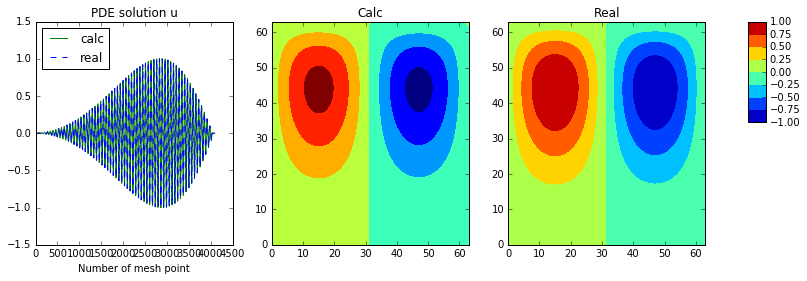

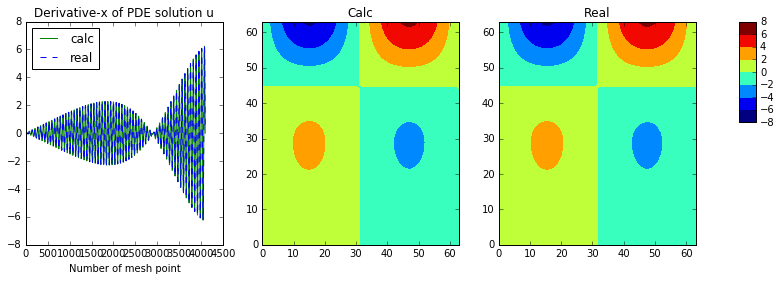

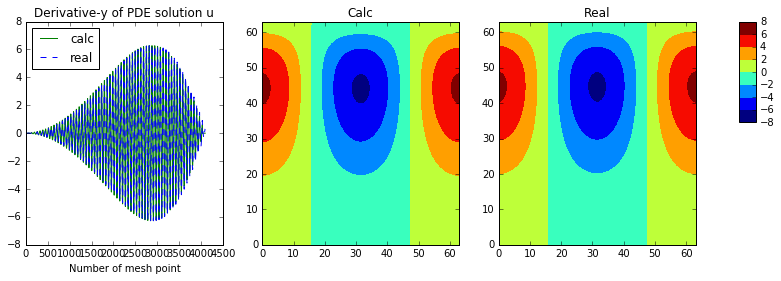

In [8]:
PDE.present_res()
PDE.plot_res()

### The following variables and values are saved in Pde class instance after calculation (some of them may be None):

- AMEn results: iters, max_dx, max_res, max_rank, (in dictionary algss_par)
- Linear system parameters: a_erank, rhs_erank,
- Calculated solution: u_calc, u_calc_ranks, u_calc_erank and it's error u_err, 
- Analytical solution: u_real, u_real_ranks, u_real_erank, 
- Calculated derivatives: ud_calc (list) and it's errors ud_err (list), 
- Analytical derivatives: ud_real, ud_err (lists), ud_err,
- Calculated energy: en_calc and it's error en_err,
- Analytical energy: en_real,
- Times: t_full and others.

In [9]:
print PDE.u_calc
# transformation of TT-vector to numpy format:
print type(PDE.u_calc.full().flatten('F'))
# and so on ...

This is a 12-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=4, n(2)=2 
r(3)=5, n(3)=2 
r(4)=4, n(4)=2 
r(5)=4, n(5)=2 
r(6)=4, n(6)=2 
r(7)=6, n(7)=2 
r(8)=6, n(8)=2 
r(9)=6, n(9)=2 
r(10)=4, n(10)=2 
r(11)=2, n(11)=2 
r(12)=1 

<type 'numpy.ndarray'>


### The following variables are saved in PDESolver class instance after calculation:

- For SolverFs: iD (list), F, Bi, A, rhs, R (list), H (list), wx

In [10]:
print 'Effective TT-ranks of varibles'
print 'iD[0]: %-4.1f'%PDESolver.iD[0].erank, 'iD[1]: %-4.1f'%PDESolver.iD[1].erank,
print 'F: %-4.1f'%PDESolver.F.erank,
print 'Bi: %-4.1f'%PDESolver.Bi.erank,
print 'A: %-4.1f'%PDESolver.A.erank,
print 'rhs: %-4.1f'%PDESolver.rhs.erank
print 'R[0]: %-4.1f'%PDESolver.R[0].erank, 'R[1]: %-4.1f'%PDESolver.R[1].erank
print 'H[0]: %-4.1f'%PDESolver.H[0].erank, 'H[1]: %-4.1f'%PDESolver.H[1].erank
print 'wx: %-4.1f'%PDESolver.wx.erank

Effective TT-ranks of varibles
iD[0]: 7.0  iD[1]: 7.0  F: 5.4  Bi: 2.0  A: 30.6 rhs: 8.0 
R[0]: 14.7 R[1]: 23.7
H[0]: 15.3 H[1]: 23.7
wx: 5.5 
